In [2]:
%%capture
import sys  # noqa: F401

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -U daxer


In [3]:
workspace_name = "90486-Turkey-IM-ALTR S&M reports"
dataset_name = "ALT Sales & Pricing Dashboard"
from daxer.Daxer import Daxer
daxer_instance = Daxer(endpoint="premium", workspace_name=workspace_name)
daxer_instance.authenticate()
dax_query = "Evaluate 'Sales Report'"
query_result = daxer_instance.execute_query_premium_dataset(dataset_name, dax_query)
query_result

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CHPGZKPQ5 to authenticate.
token expires at 2025-03-14 07:44:51


,Sales Report[SAP_CUST_NO],Sales Report[SECTOR],Sales Report[CUST_NO],Sales Report[INVOICE_NO],Sales Report[DEL_DATE],Sales Report[PROD_NO],Sales Report[SAP_PROD_NO],Sales Report[PROD_DESCR],Sales Report[QTY],Sales Report[UNIT],...,Sales Report[Average Cost],Sales Report[MARKET_DOMAIN_CODE],Sales Report[MARKET_DOMAIN_DESCR],Sales Report[Short Sector],Sales Report[NEXTMonth Ref],Sales Report[EUR],Sales Report[New Sector],Sales Report[CP for Appl.],Sales Report[Cluster],Sales Report[Application]
0,1010002643,AF0900...Machinery and Metal Furniture,A26431,AA0913,2019-12-13T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202001,6.48094,None,A26431IM Services PG,NİLÜFER OSB,None
1,1010002643,AF0900...Machinery and Metal Furniture,A26431,AA1617,2019-12-22T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202001,6.48094,None,A26431IM Services PG,NİLÜFER OSB,None
2,1010002643,AF0900...Machinery and Metal Furniture,A26431,AA2460,2019-12-31T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202001,6.48094,None,A26431IM Services PG,NİLÜFER OSB,None
3,1010002643,AF0900...Machinery and Metal Furniture,A26431,AA3698,2020-01-14T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202002,6.57510,None,A26431IM Services PG,NİLÜFER OSB,None
4,1010002643,AF0900...Machinery and Metal Furniture,A26431,AA3913,2020-01-16T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202002,6.57510,None,A26431IM Services PG,NİLÜFER OSB,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607639,1010006583,AF0400...Shipyard,ZET017,AN6405,2023-05-17T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202306,21.42550,E&P,ZET017IM Services PG,"BORNOVA, KPAŞA, TURGUTLU",None
607640,1010006874,AF0300...Modules and parts for Motor Vehicles,ZET019,AP8085,2023-11-09T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202312,30.84690,E&P,ZET019IM Services PG,"SAKARYA, HENDEK",None
607641,1010000196,AF1000...Fabricated Metal Products,ZG1961,AP7920,2023-11-09T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0201,A&F,AF,202312,30.84690,E&P,ZG1961IM Services PG,"ANKARA, GÖLBAŞI",None
607642,1010001258,FP0400...Seafood Processing,ZP2582,AB0452,2020-03-28T00:00:00,009100,9100,TESLIMAT - TUP,1.0,PCS,...,4231.091667,0203,F&P,FP,202004,6.98870,F&P,ZP2582IM Services PG,CLUST DIŞI,None


In [4]:
df_copy = query_result.copy()


In [5]:
df_original = query_result.copy()


In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report

# Veri yükleme (df_copy'nin yüklü olduğunu varsayıyoruz)
df_copy['Sales Report[DEL_DATE]'] = pd.to_datetime(df_copy['Sales Report[DEL_DATE]'], errors='coerce')

# Son 2 yılı filtreleme
two_years_ago = pd.Timestamp.today() - pd.DateOffset(years=2)
df_copy = df_copy[df_copy['Sales Report[DEL_DATE]'] >= two_years_ago]

# Sadece "IM IPG" içerenleri filtreleme
df_copy = df_copy[df_copy['Sales Report[F&A_1]'] == 'IM IPG']

# Kullanılacak sütunları seçme
df_copy = df_copy[['Sales Report[NAT_CUST_ID]', 'Sales Report[DEL_DATE]', 'Sales Report[QTY]', 'Sales Report[F&A_2]', 'Sales Report[MONTH_REF]']]

/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [8]:
# MONTH_REF sütununu string'e çevirme
df_copy['Sales Report[MONTH_REF]'] = df_copy['Sales Report[MONTH_REF]'].astype(str)

# Yılı ve ayı ayırma
df_copy['YEAR'] = df_copy['Sales Report[MONTH_REF]'].str[:4].astype(int)
df_copy['MONTH'] = df_copy['Sales Report[MONTH_REF]'].str[4:].astype(int)

# Tarih sütunu oluşturma
df_copy['DATE'] = pd.to_datetime(df_copy[['YEAR', 'MONTH']].assign(DAY=1))

In [53]:
last_shipment_dates = df_copy.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]'])['Sales Report[DEL_DATE]'].max()

# Recency hesaplama
reference_date = pd.Timestamp(2025, 2, 28)
recency = (reference_date - last_shipment_dates).dt.days

# Aylık toplam harcama ve alışveriş sıklığını hesaplama
customer_rfm = df_copy.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]', 'YEAR', 'MONTH', 'DATE']).agg(
    Total_Spending=('Sales Report[QTY]', 'sum'),
    Frequency=('Sales Report[DEL_DATE]', 'count')
).reset_index()

# Recency değerini ekleme
customer_rfm['Recency'] = recency.reset_index(drop=True)

# Churn hesaplama (Son 3 ayda alışveriş yapmamışsa Churn)
customer_rfm['Churn'] = customer_rfm['Recency'] >= 90

In [39]:
customer_rfm = customer_rfm.sort_values(by='DATE')
customer_rfm['Total_Spending_Lag1'] = customer_rfm.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]'])['Total_Spending'].shift(1)
customer_rfm['Total_Spending_Lag2'] = customer_rfm.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]'])['Total_Spending'].shift(2)
customer_rfm['Frequency_Lag1'] = customer_rfm.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]'])['Frequency'].shift(1)
customer_rfm['Frequency_Lag2'] = customer_rfm.groupby(['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]'])['Frequency'].shift(2)

In [40]:
customer_rfm['Churn_Next_Month'] = customer_rfm.groupby(['Sales Report[NAT_CUST_ID]','Sales Report[F&A_2]'])['Churn'].shift(-1)

In [41]:
customer_rfm = customer_rfm.fillna(0)

In [42]:
customer_rfm['Churn_Next_Month'] =customer_rfm['Churn_Next_Month'].astype(int)

In [43]:
customer_rfm

,Sales Report[NAT_CUST_ID],Sales Report[F&A_2],YEAR,MONTH,DATE,Total_Spending,Frequency,Recency,Churn,Total_Spending_Lag1,Total_Spending_Lag2,Frequency_Lag1,Frequency_Lag2,Churn_Next_Month
0,5MT00000,IM IPG ARMIX,2023,3,2023-03-01,20.0,3,380.0,True,0.0,0.0,0.0,0.0,1
26760,TAT00142,IM IPG ARMIX,2023,3,2023-03-01,6.0,1,0.0,False,0.0,0.0,0.0,0.0,0
8376,DOT02452,IM IPG ARMIX,2023,3,2023-03-01,5.0,1,0.0,False,0.0,0.0,0.0,0.0,0
21658,PAT00152,IM IPG GAR,2023,3,2023-03-01,11.0,5,0.0,False,0.0,0.0,0.0,0.0,0
30789,YAT00831,IM IPG GOX,2023,3,2023-03-01,8.0,2,0.0,False,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20436,NUT00179,IM IPG ARMIX,2025,3,2025-03-01,15.0,1,0.0,False,30.0,30.0,2.0,2.0,0
12857,GOT00005,IM IPG GOX,2025,3,2025-03-01,4.0,1,0.0,False,8.0,4.0,3.0,1.0,0
22770,PRT00501,IM IPG GAR,2025,3,2025-03-01,7.0,3,0.0,False,24.0,21.0,8.0,9.0,0
24886,SET00606,IM IPG GAR,2025,3,2025-03-01,2.0,1,0.0,False,4.0,5.0,1.0,1.0,0


In [44]:
# Bağımsız değişkenler (X) ve hedef değişken (y)
X = customer_rfm[['Total_Spending', 'Frequency', 'Recency', 'Total_Spending_Lag1', 'Total_Spending_Lag2', 'Frequency_Lag1', 'Frequency_Lag2']]
y = customer_rfm['Churn_Next_Month']

# Zaman serisi bölmeli (TimeSeriesSplit) oluşturma
tscv = TimeSeriesSplit(n_splits=5)

# Model eğitimi ve test aşaması
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # XGBoost modeli eğitme
    model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    model.fit(X_train, y_train)

    # Modeli test etme
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [07:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [07:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5185
           1       0.44      0.37      0.40       180

    accuracy                           0.96      5365
   macro avg       0.71      0.68      0.69      5365
weighted avg       0.96      0.96      0.96      5365

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5223
           1       0.42      0.30      0.35       142

    accuracy                           0.97      5365
   macro avg       0.70      0.65      0.67      5365
weighted avg       0.97      0.97      0.97      5365



/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [07:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [07:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5206
           1       0.40      0.29      0.33       159

    accuracy                           0.97      5365
   macro avg       0.69      0.64      0.66      5365
weighted avg       0.96      0.97      0.96      5365

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5205
           1       0.42      0.39      0.40       160

    accuracy                           0.97      5365
   macro avg       0.70      0.69      0.69      5365
weighted avg       0.96      0.97      0.97      5365

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5277
           1       0.26      0.28      0.27        88

    accuracy                           0.98      5365
   macro avg       0.62      0.64      0.63      5365
weighted avg       0.98      0.98      0.98      5365



/home/ec2-user/SageMaker/envs/default_kernel/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [07:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [45]:
# Müşteri bazında churn olasılıklarını hesaplama
customer_rfm['Churn_Risk'] = model.predict_proba(X)[:, 1]

# Eşik değeri belirleme
threshold = 0.5
customer_rfm['Churn_Prediction'] = (customer_rfm['Churn_Risk'] > threshold).astype(int)

In [46]:
# 📌 7. MÜŞTERİLERİ SINIFLANDIRMA

def categorize_customer(row):
    if row['Recency'] >= 90:  
        return 'Churned'
    elif row['Churn_Risk'] > threshold:
        return 'At Risk'
    else:
        return 'Active'

customer_rfm['Churn_Status'] = customer_rfm.apply(categorize_customer, axis=1)

# 📌 8. SONUÇLARI İNCELEME

risk_list = customer_rfm[['Sales Report[NAT_CUST_ID]', 'Churn_Risk', 'Churn_Status', 'Churn']]
print(risk_list.head())

# "At Risk" müşterileri listeleme
at_risk_customers = risk_list[risk_list['Churn_Status'] == 'At Risk']
print("At Risk Müşteriler:", at_risk_customers)

      Sales Report[NAT_CUST_ID]  Churn_Risk Churn_Status  Churn
0                      5MT00000    0.660662      Churned   True
26760                  TAT00142    0.000364       Active  False
8376                   DOT02452    0.000364       Active  False
21658                  PAT00152    0.000450       Active  False
30789                  YAT00831    0.000310       Active  False
At Risk Müşteriler:      Sales Report[NAT_CUST_ID]  Churn_Risk Churn_Status  Churn
1993                  ANT00717    0.760042      At Risk  False
2632                  ART02972    0.725164      At Risk  False
2550                  ART02969    0.865871      At Risk  False
2074                  ANT02580    0.633692      At Risk  False
2057                  ANT01327    0.606001      At Risk  False
...                        ...         ...          ...    ...
2733                  ART02974    0.563282      At Risk  False
1714                  ALT02927    0.757614      At Risk  False
683                   AFT0059

In [47]:
risk_list['Churn_Status'].value_counts()

Active     30955
Churned      996
At Risk      243
Name: Churn_Status, dtype: int64

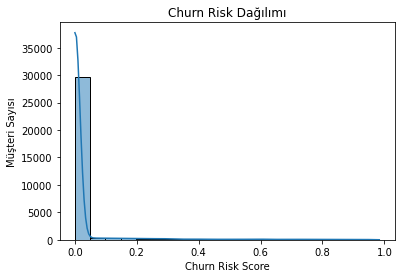

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(customer_rfm['Churn_Risk'], bins=20, kde=True)
plt.xlabel("Churn Risk Score")
plt.ylabel("Müşteri Sayısı")
plt.title("Churn Risk Dağılımı")
plt.show()

In [49]:
print(customer_rfm['Churn_Risk'].describe())

count    32194.000000
mean         0.029776
std          0.120760
min          0.000008
25%          0.000406
50%          0.000861
75%          0.002367
max          0.983483
Name: Churn_Risk, dtype: float64


In [50]:
customer_info = df_original[['Sales Report[NAT_CUST_ID]', 'Sales Report[ACCOUNT_NAME]']].drop_duplicates()
churn_status_atrisk = customer_rfm[['Sales Report[NAT_CUST_ID]', 'Sales Report[F&A_2]','Churn_Risk','Churn_Status']]
churn_status_atrisk=churn_status_atrisk.merge(customer_info,on='Sales Report[NAT_CUST_ID]',how='left')
churn_status_atrisk

,Sales Report[NAT_CUST_ID],Sales Report[F&A_2],Churn_Risk,Churn_Status,Sales Report[ACCOUNT_NAME]
0,5MT00000,IM IPG ARMIX,0.660662,Churned,5M MAKİNA İNŞAAT GIDA SANAYİ VE TİCARET LTD. ŞTİ
1,TAT00142,IM IPG ARMIX,0.000364,Active,TAMSAN KOMPRESÖR SAN.VE TİC.AŞ
2,DOT02452,IM IPG ARMIX,0.000364,Active,DOSTKUR INSAAT TAAHHÜT MÜT. TIC. VE SAN. LTD.STI.
3,PAT00152,IM IPG GAR,0.000450,Active,PANDA ALÜMİNYUM A.Ş.
4,YAT00831,IM IPG GOX,0.000310,Active,YAŞALAR KALIP YEDEK PARÇA SAN.TİC.LTD.ŞTİ.
...,...,...,...,...,...
39399,PRT00501,IM IPG GAR,0.000361,Active,PRESİMSAN HİDROLİK MAKİNA KALIP YEDEK PARÇA SA...
39400,PRT00501,IM IPG GAR,0.000361,Active,PRESİMSAN HİDROLİK MAKİNA KALIP YEDEK PARÇA SA...
39401,SET00606,IM IPG GAR,0.000548,Active,SERİN TREYLER A.Ş.
39402,SET00606,IM IPG GAR,0.000548,Active,SERİN OTOMOTİV SAN. TİC . A.Ş.


In [51]:
churn_status_atrisk = churn_status_atrisk[churn_status_atrisk['Churn_Status'] == 'At Risk']

churn_status_atrisk

,Sales Report[NAT_CUST_ID],Sales Report[F&A_2],Churn_Risk,Churn_Status,Sales Report[ACCOUNT_NAME]
584,ANT00717,IM IPG ARMIX,0.760042,At Risk,ANSAN HİDROLİK A.Ş.
585,ANT00717,IM IPG ARMIX,0.760042,At Risk,ANSAN HİDROLİK SAN.MAK.İNŞ. TURZ.TAAH.TİC.LTD....
603,ART02972,IM IPG GOX,0.725164,At Risk,ARISAN YAPISAL ÇELİK A.Ş.
609,ART02969,IM IPG ARMIX,0.865871,At Risk,ARMTEK ELEKTRİK SANAYİ VE TİCARET A.Ş.
679,ANT02580,IM IPG ARMIX,0.633692,At Risk,ANADOLU DÖKÜM SANAYİ A.Ş.
...,...,...,...,...,...
37650,ALT02927,IM IPG GOX,0.757614,At Risk,ALDEM ÇELİK ENDÜSTRİ SAN. VE TİC. A.Ş.
38705,AFT00597,IM IPG ARMIX,0.735931,At Risk,AFŞA METAL MÜHENDİSLİK SANAYİ VE TİC. A.Ş.
38706,AFT00597,IM IPG ARMIX,0.735931,At Risk,AFŞA METAL MÜHENDİSLİK SAN.VE TİC.LTD.ŞTİ.
38884,AKT02946,IM IPG ARMIX,0.687318,At Risk,AKYAPAK ULUSLARARASI DIŞ TİCARET MAKİNA SAN. V...
